# 1. Reading From Dataset
First and foremost, we'll need a dataset to train your model because it's virtually impossible to complete a machine-learning project without one, right? :) We can easily read the dataset thanks to [Hossein Zaredar](https://github.com/HosseinZaredar/Computational-Intelligence/blob/main/read_MNIST.py)'s help

In [1]:
import numpy as np
import matplotlib.pyplot as plt

NUMBER_OF_PIXELS = 784

To read from the files, we construct a function named `read_from_file` that does nothing but that.We know where to look for each data based on the information given by MNIST

In [2]:
def read_from_file(image_address, label_address):
    images_file = open(image_address, 'rb')
    images_file.seek(4)  # Positions the cursor to the 4th byte.
    number_of_images = int.from_bytes(images_file.read(4), 'big')  # reads 4 bytes in big endian order
    images_file.seek(16)  # Positions the cursor to the 16th byte.
    
    labels_file = open(label_address, 'rb')
    labels_file.seek(8)
    
    result_set = []
    for n in range(number_of_images):
        image = np.zeros((NUMBER_OF_PIXELS, 1))
        for i in range(NUMBER_OF_PIXELS):
            image[i, 0] = int.from_bytes(images_file.read(1), 'big') / 255

        label_value = int.from_bytes(labels_file.read(1), 'big')
        label = np.zeros((10, 1))  # Since we have 10 numbers from 0 to 9
        label[label_value, 0] = 1

        result_set.append((image, label))
    
    return result_set

then we call that function to create our train & test set

In [3]:
train_set = read_from_file("digit_images/train-images.idx3-ubyte", "digit_images/train-labels.idx1-ubyte")
test_set = read_from_file("digit_images/t10k-images.idx3-ubyte", "digit_images/t10k-labels.idx1-ubyte")

At the end of this section, we plot an image just to make sure we've done this part rightly.

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]])

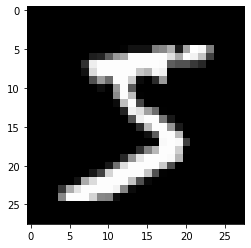

In [4]:
plt.imshow(train_set[0][0].reshape(28, -1), 'gray')
train_set[0][1]

# 2. Feedforward
As we all know, in order to calculate output in a neural network based on inputs, we must apply the following formula on each layer:  
$$a^{(L+1)} = \sigma(W^{(L+1)}× a^{(L)} + b^{(L+1)})$$

Therefore in implementation, for weights between layers, we assign a k×n matrix. Assume "k" is the number of neurons on the next layer, and "n" is the number of neurons on the current layer. As a result, the weights of a single neuron on the next layer are shown in each row of our matrix W.

In [5]:
# Allocate W matrix and vector b for each layer.

# Initialize W from standard normal distribution
W1 = np.random.normal(size=(16, NUMBER_OF_PIXELS))
W2 = np.random.normal(size=(16, 16))
W3 = np.random.normal(size=(10, 16))

# Initialize b = 0, for each layer.
b1 = np.zeros((16, 1))
b2 = np.zeros((16, 1))
b3 = np.zeros((10, 1))

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

At this step of this project, after initializing W matrices and bias vectors, we separate the first 100 images of our train dataset and calculate the output of that based on the given formula.

In the end, we report the accuracy, which is the number of true estimations divided by the number of images (which is 100 in our scenario). Regarding that the learning process has not proceeded, we expect to have an accuracy of around 10%.

In [7]:
number_of_correct_estimations = 0
total_numbers = 100

for train_data in train_set[:total_numbers]:
    a0 = train_data[0]
    a1 = sigmoid(W1 @ a0 + b1)
    a2 = sigmoid(W2 @ a1 + b2)
    a3 = sigmoid(W3 @ a2 + b3)
    
    predicted_number = np.where(a3 == np.amax(a3))
    real_number = np.where(train_data[1] == np.amax(train_data[1]))
    
    if predicted_number == real_number:
        number_of_correct_estimations += 1

print(f"Accuracy: {number_of_correct_estimations / total_numbers}")

Accuracy: 0.14


## 3. Backpropagation
![Layers](assets/Layers.jpg)
As we know, the learning process in a neural network is equivalent to minimize the cost function  
$$Cost =\sum_{j=0}^{n_{L} - 1} (a_{j}^{(L)} - y_{j})^2$$
That is done with the help of Gradient Descent. To do that, we take a partial derivative of the cost function with respect to all the parameters to make the Gradient vector.
$$(W, b) = (W, b) - \alpha\nabla Cost$$
We take the derivatives with the help of backpropagation.

In [8]:
# Hyperparameters
batch_size = 10
learning_rate = 1
number_of_epochs = 20

### How to use backpropagation?
Regarding we have four layers (one input layer, one output layer, and two hidden layers), if we want to use backpropagation, at first, we have to define what we are dealing with.  
Let us suppose we name our layers from 0 to 3, then we have:
$$Cost =\sum_{j=0}^{9} (a_{j}^{(L)} - y_{j})^2$$
Each neuron at the last layer is equal to:
$$a_{j}^{(3)} = \sigma(z_{j}^{(3)})$$
And $z_{j}^{(3)}$ is equal to:
$$z_{j}^{(3)} = \sum_{j=0}^{9} w_{jk}^{(3)}a_{k}^{(2)} + b_{j}^{(2)}$$
### The last layer
##### Weight
If we apply the chain rule, we can reach to the following formula:  
$$\displaystyle \frac{\partial Cost}{\partial w_{jk}^{(3)}} = \displaystyle \frac{\partial Cost}{\partial a_{j}^{(3)}} × \displaystyle \frac{\partial a_{j}^{(3)}}{\partial z_{j}^{(3)}} × \displaystyle \frac{\partial z_{j}^{(3)}}{\partial w_{jk}^{(3)}} $$

$$\displaystyle \frac{\partial Cost}{\partial w_{jk}^{(3)}} = 2(a_{j}^{(3)} - y_{j}) × \sigma^{'}(z_{j}^{(3)})×a_{k}^{(2)}$$

##### Bias
$$\displaystyle \frac{\partial Cost}{\partial b_{j}^{(3)}} = \displaystyle \frac{\partial Cost}{\partial a_{j}^{(3)}} × \displaystyle \frac{\partial a_{j}^{(3)}}{\partial z_{j}^{(3)}} × \displaystyle \frac{\partial z_{j}^{(3)}}{\partial b_{j}^{(3)}} $$

$$\displaystyle \frac{\partial Cost}{\partial b_{j}^{(3)}} = 2(a_{j}^{(3)} - y_{j}) × \sigma^{'}(z_{j}^{(3)})× 1$$

##### Activation
We also need to calculate partial derivatives with respect to the activation output of the previous layer. It helps us for backpropagation as we see further.  
$$\displaystyle \frac{\partial Cost}{\partial a_{k}^{(2)}} = \sum_{j=0}^{9} \displaystyle \frac{\partial Cost}{\partial a_{j}^{(3)}} × \displaystyle \frac{\partial a_{j}^{(3)}}{\partial z_{j}^{(3)}} × \displaystyle \frac{\partial z_{j}^{(3)}}{\partial a_{k}^{(2)}} $$

$$\displaystyle \frac{\partial Cost}{\partial a_{k}^{(2)}} = \sum_{j=0}^{9} (2(a_{j}^{(3)} - y_{j}) × \sigma^{'}(z_{j}^{(3)})× w_{jk}^{(3)}) $$

### 3rd layer
##### Weight
$$\displaystyle \frac{\partial Cost}{\partial w_{km}^{(2)}} = \displaystyle \frac{\partial Cost}{\partial a_{k}^{(2)}} × \displaystyle \frac{\partial a_{k}^{(2)}}{\partial z_{k}^{(2)}} × \displaystyle \frac{\partial z_{k}^{(2)}}{\partial w_{km}^{(2)}} $$

$$\displaystyle \frac{\partial Cost}{\partial w_{km}^{(2)}} =  \displaystyle \frac{\partial Cost}{\partial a_{k}^{(2)}} × \sigma^{'}(z_{k}^{(2)})×a_{m}^{(1)}$$

##### Bias
$$\displaystyle \frac{\partial Cost}{\partial b_{k}^{(2)}} = \displaystyle \frac{\partial Cost}{\partial a_{k}^{(2)}} × \displaystyle \frac{\partial a_{k}^{(2)}}{\partial z_{k}^{(2)}} × \displaystyle \frac{\partial z_{k}^{(2)}}{\partial b_{k}^{(2)}} $$

$$\displaystyle \frac{\partial Cost}{\partial b_{k}^{(2)}} = \displaystyle \frac{\partial Cost}{\partial a_{k}^{(2)}} × \sigma^{'}(z_{k}^{(2)})× 1$$

##### Activation
$$\displaystyle \frac{\partial Cost}{\partial a_{m}^{(1)}} = \sum_{k=0}^{15} \displaystyle \frac{\partial Cost}{\partial a_{k}^{(2)}} × \displaystyle \frac{\partial a_{k}^{(2)}}{\partial z_{k}^{(2)}} × \displaystyle \frac{\partial z_{k}^{(2)}}{\partial a_{m}^{(1)}} $$

$$\displaystyle \frac{\partial Cost}{\partial a_{m}^{(1)}} = \sum_{k=0}^{15} (\displaystyle \frac{\partial Cost}{\partial a_{k}^{(2)}} × \sigma^{'}(z_{k}^{(2)})× w_{km}^{(2)}) $$

### 2nd layer
##### Weight
$$\displaystyle \frac{\partial Cost}{\partial w_{mv}^{(1)}} = \displaystyle \frac{\partial Cost}{\partial a_{m}^{(1)}} × \displaystyle \frac{\partial a_{m}^{(1)}}{\partial z_{m}^{(1)}} × \displaystyle \frac{\partial z_{m}^{(1)}}{\partial w_{mv}^{(1)}} $$

$$\displaystyle \frac{\partial Cost}{\partial w_{mv}^{(1)}} =  \displaystyle \frac{\partial Cost}{\partial a_{m}^{(1)}} × \sigma^{'}(z_{m}^{(1)})×a_{v}^{(0)}$$

##### Bias
$$\displaystyle \frac{\partial Cost}{\partial b_{m}^{(1)}} = \displaystyle \frac{\partial Cost}{\partial a_{m}^{(1)}} × \displaystyle \frac{\partial a_{m}^{(1)}}{\partial z_{m}^{(1)}} × \displaystyle \frac{\partial z_{m}^{(1)}}{\partial b_{m}^{(1)}} $$

$$\displaystyle \frac{\partial Cost}{\partial b_{m}^{(1)}} = \displaystyle \frac{\partial Cost}{\partial a_{m}^{(1)}} × \sigma^{'}(z_{m}^{(1)})× 1$$

In [9]:
%%time
total_costs = []
# Initialize W with random normal distribution for each layer.
W1 = np.random.normal(size=(16, NUMBER_OF_PIXELS))
W2 = np.random.normal(size=(16, 16))
W3 = np.random.normal(size=(10, 16))

# Initialize b = 0, for each layer.
b1 = np.zeros((16, 1))
b2 = np.zeros((16, 1))
b3 = np.zeros((10, 1))

for epoch in range(number_of_epochs):
    batches = [train_set[x:x+batch_size] for x in range(0, 100, batch_size)]
    for batch in batches:
        # allocate grad_W matrix for each layer
        grad_W1 = np.zeros((16, NUMBER_OF_PIXELS))
        grad_W2 = np.zeros((16, 16))
        grad_W3 = np.zeros((10, 16))
        # allocate grad_b for each layer
        grad_b1 = np.zeros((16, 1))
        grad_b2 = np.zeros((16, 1))
        grad_b3 = np.zeros((10, 1))
        
        for image, label in batch:
            # compute the output (image is equal to a0)
            a1 = sigmoid(W1 @ image + b1)
            a2 = sigmoid(W2 @ a1 + b2)
            a3 = sigmoid(W3 @ a2 + b3)
            
            # ---- Last layer
            # weight
            for j in range(grad_W3.shape[0]):
                for k in range(grad_W3.shape[1]):
                    grad_W3[j, k] += 2 * (a3[j, 0] - label[j, 0]) * a3[j, 0] * (1 - a3[j, 0]) * a2[k, 0]
            
            # bias
            for j in range(grad_b3.shape[0]):
                    grad_b3[j, 0] += 2 * (a3[j, 0] - label[j, 0]) * a3[j, 0] * (1 - a3[j, 0])
            
            # ---- 3rd layer
            # activation
            delta_3 = np.zeros((16, 1))
            for k in range(16):
                for j in range(10):
                    delta_3[k, 0] += 2 * (a3[j, 0] - label[j, 0]) * a3[j, 0] * (1 - a3[j, 0]) * W3[j, k]
            
            # weight
            for k in range(grad_W2.shape[0]):
                for m in range(grad_W2.shape[1]):
                    grad_W2[k, m] += delta_3[k, 0] * a2[k,0] * (1 - a2[k, 0]) * a1[m, 0]
            
            # bias
            for k in range(grad_b2.shape[0]):
                    grad_b2[k, 0] += delta_3[k, 0] * a2[k, 0] * (1 - a2[k, 0])
                    
            # ---- 2nd layer
            # activation
            delta_2 = np.zeros((16, 1))
            for m in range(16):
                for k in range(16):
                    delta_2[m, 0] += delta_3[k, 0] * a2[k, 0] * (1 - a2[k, 0]) * W2[k, m]
            
            # weight
            for m in range(grad_W1.shape[0]):
                for v in range(grad_W1.shape[1]):
                    grad_W1[m, v] += delta_2[m, 0] * a1[m,0] * (1 - a1[m, 0]) * image[v, 0]
                    
            # bias
            for m in range(grad_b1.shape[0]):
                    grad_b1[m, 0] += delta_2[m, 0] * a1[m, 0] * (1 - a1[m, 0])
        
        W3 = W3 - (learning_rate * (grad_W3 / batch_size))
        W2 = W2 - (learning_rate * (grad_W2 / batch_size))
        W1 = W1 - (learning_rate * (grad_W1 / batch_size))
        
        b3 = b3 - (learning_rate * (grad_b3 / batch_size))
        b2 = b2 - (learning_rate * (grad_b2 / batch_size))
        b1 = b1 - (learning_rate * (grad_b1 / batch_size))
    
    # calculate cost average per epoch
    cost = 0
    for train_data in train_set[:100]:
        a0 = train_data[0]
        a1 = sigmoid(W1 @ a0 + b1)
        a2 = sigmoid(W2 @ a1 + b2)
        a3 = sigmoid(W3 @ a2 + b3)

        for j in range(10):
            cost += np.power((a3[j, 0] - train_data[1][j,  0]), 2)
            
    cost /= 100
    total_costs.append(cost)    

Wall time: 58.9 s


Accuracy: 0.96


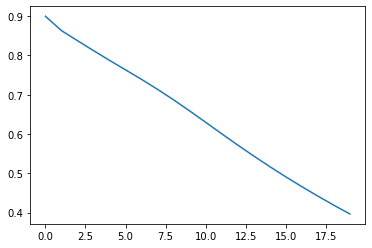

In [10]:
epoch_size = [x for x in range(20)]
plt.plot(epoch_size, total_costs)

for train_data in train_set[:100]:
    a0 = train_data[0]
    a1 = sigmoid(W1 @ a0 + b1)
    a2 = sigmoid(W2 @ a1 + b2)
    a3 = sigmoid(W3 @ a2 + b3)
    
    predicted_number = np.where(a3 == np.amax(a3))
    real_number = np.where(train_data[1] == np.amax(train_data[1]))
    
    if predicted_number == real_number:
        number_of_correct_estimations += 1
        
print(f"Accuracy: {number_of_correct_estimations / 100}")

# 4. Vectorization
Because of the long execution time, we've only dealt on 100 first pictures so far. We use vectorization to solve this problem. It implies that we use matrix operations instead of for loops to measure each entry of matrices separately.

As a result, the processing time would be significantly reduced. The explanation for this is that matrix operations can run in parallel on multi-core CPUs. Furthermore, today's processors have instructions for working with large vector data, which will be much more effective.

We have implemented the second section (Feedforward) in a vectorized way. Now we're attempting to do the same thing with backpropagation.
___

In vectorized notiation, we have:
$$Cost =(\overrightarrow{a}^{(3)} - \overrightarrow{y})^{T}(\overrightarrow{a}^{(3)} - \overrightarrow{y})$$
The activation vector at the last layer is equal to:
$$\overrightarrow{a}^{(3)} = \sigma(\overrightarrow{z}^{(3)})$$
And $\overrightarrow{z}^{(3)}$ is equal to:
$$\overrightarrow{z}^{(3)} = W^{(3)}\overrightarrow{a}^{(2)} + \overrightarrow{b}^{(2)}$$
### The last layer
##### Weight
$$\displaystyle \frac{\partial Cost}{\partial W^{(3)}} = 2(\overrightarrow{a}^{(3)} - \overrightarrow{y})\overrightarrow{a}^{(3)}(1 - \overrightarrow{a}^{(3)}) \bullet \overrightarrow{a}^{(2)}$$
##### Bias
$$\displaystyle \frac{\partial Cost}{\partial \overrightarrow{b}^{(3)}} = 2 (\overrightarrow{a}^{(3)} - \overrightarrow{y}) \overrightarrow{a}^{(3)}(1 - \overrightarrow{a}^{(3)})$$
##### Activation
$$\displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(2)}} = {W_{3}^{T}} (2(\overrightarrow{a}^{(3)} - \overrightarrow{y}) \overrightarrow{a}^{(3)}(1 - \overrightarrow{a}^{(3)})) $$

### 3rd Layer
##### Weight
$$\displaystyle \frac{\partial Cost}{\partial W^{(2)}} = \displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(2)}}\overrightarrow{a}^{(2)}(1 - \overrightarrow{a}^{(2)}) \bullet \overrightarrow{a}^{(1)}$$
##### Bias
$$\displaystyle \frac{\partial Cost}{\partial \overrightarrow{b}^{(2)}} = (\displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(2)}})\overrightarrow{a}^{(2)}(1 - \overrightarrow{a}^{(2)})$$
##### Activation 
$$\displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(1)}} = {W_{2}^{T}} (\displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(2)}}) \overrightarrow{a}^{(2)}(1 - \overrightarrow{a}^{(2)})) $$

### 2nd
##### Weight
$$\displaystyle \frac{\partial Cost}{\partial W^{(1)}} = \displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(1)}}\overrightarrow{a}^{(1)}(1 - \overrightarrow{a}^{(1)}) \bullet \overrightarrow{a}^{(0)}$$
##### Bias
$$\displaystyle \frac{\partial Cost}{\partial \overrightarrow{b}^{(1)}} = (\displaystyle \frac{\partial Cost}{\partial \overrightarrow{a}^{(1)}})\overrightarrow{a}^{(1)}(1 - \overrightarrow{a}^{(1)})$$

In [11]:
%%time
# Allocate W matrix and vector b for each layer.

# Initialize W with random normal distribution for each layer. 
W1 = np.random.normal(size=(16, NUMBER_OF_PIXELS))
W2 = np.random.normal(size=(16, 16))
W3 = np.random.normal(size=(10, 16))

# Initialize b = 0, for each layer.
b1 = np.zeros((16, 1))
b2 = np.zeros((16, 1))
b3 = np.zeros((10, 1))

total_costs = []
batches = [train_set[x:x+batch_size] for x in range(0, 100, batch_size)]
for epoch in range(number_of_epochs):
    for batch in batches:
        # allocate grad_W matrix for each layer
        grad_W1 = np.zeros((16, NUMBER_OF_PIXELS))
        grad_W2 = np.zeros((16, 16))
        grad_W3 = np.zeros((10, 16))
        # allocate grad_b for each layer
        grad_b1 = np.zeros((16, 1))
        grad_b2 = np.zeros((16, 1))
        grad_b3 = np.zeros((10, 1))
        
        for image, label in batch:
            # compute the output (image is equal to a0)
            a1 = sigmoid(W1 @ image + b1)
            a2 = sigmoid(W2 @ a1 + b2)
            a3 = sigmoid(W3 @ a2 + b3)
            
            # ---- Last layer
            # weight
            grad_W3 += (2 * (a3 - label) * a3 * (1 - a3)) @ np.transpose(a2)
            
            # bias
            grad_b3 += 2 * (a3 - label) * a3 * (1 - a3)
            
            # ---- 3rd layer
            # activation
            delta_3 = np.zeros((16, 1))
            delta_3 += np.transpose(W3) @ (2 *(a3 - label) * (a3 * (1 - a3)))
            
            # weight
            grad_W2 += (a2 * (1 - a2) * delta_3) @ np.transpose(a1)
            
            # bias
            grad_b2 += delta_3 * a2 * (1 - a2)
                    
            # ---- 2nd layer
            # activation
            delta_2 = np.zeros((16, 1))
            delta_2 += np.transpose(W2) @ delta_3 * a2 * (1 - a2)
            
            # weight
            grad_W1 += (delta_2 * a1 * (1 - a1)) @ np.transpose(image)
                    
            # bias
            grad_b1 += delta_2 * a1 * (1 - a1)
        
        W3 = W3 - (learning_rate * (grad_W3 / batch_size))
        W2 = W2 - (learning_rate * (grad_W2 / batch_size))
        W1 = W1 - (learning_rate * (grad_W1 / batch_size))
        
        b3 = b3 - (learning_rate * (grad_b3 / batch_size))
        b2 = b2 - (learning_rate * (grad_b2 / batch_size))
        b1 = b1 - (learning_rate * (grad_b1 / batch_size))
    
    # calculate cost average per epoch
    cost = 0
    for train_data in train_set[:100]:
        a0 = train_data[0]
        a1 = sigmoid(W1 @ a0 + b1)
        a2 = sigmoid(W2 @ a1 + b2)
        a3 = sigmoid(W3 @ a2 + b3)

        for j in range(10):
            cost += np.power((a3[j, 0] - train_data[1][j,  0]), 2)
            
    cost /= 100
    total_costs.append(cost)    

Wall time: 570 ms


Accuracy: 0.67


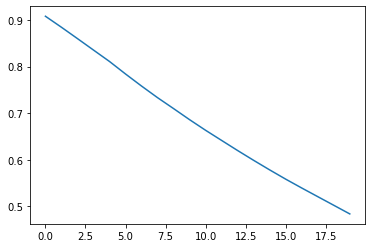

In [12]:
epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs)
number_of_correct_estimations = 0
for train_data in train_set[:100]:
    a0 = train_data[0]
    a1 = sigmoid(W1 @ a0 + b1)
    a2 = sigmoid(W2 @ a1 + b2)
    a3 = sigmoid(W3 @ a2 + b3)
    
    predicted_number = np.where(a3 == np.amax(a3))
    real_number = np.where(train_data[1] == np.amax(train_data[1]))
    
    if predicted_number == real_number:
        number_of_correct_estimations += 1
        
print(f"Accuracy: {number_of_correct_estimations / 100}")

# 5. Testing the model
We use all of our data (60k images) to learn our model now that we've optimized our implementation. Finally, we measure the model's accuracy using test results.

In [13]:
batch_size = 50
learning_rate = 1
number_of_epochs = 5

In [14]:
%%time
total_costs = []
# Initialize W with random normal distribution for each layer.
W1 = np.random.normal(size=(16, NUMBER_OF_PIXELS))
W2 = np.random.normal(size=(16, 16))
W3 = np.random.normal(size=(10, 16))

# Initialize b = 0, for each layer.
b1 = np.zeros((16, 1))
b2 = np.zeros((16, 1))
b3 = np.zeros((10, 1))

for epoch in range(number_of_epochs):
    np.random.shuffle(train_set)
    batches = [train_set[x:x+batch_size] for x in range(0, len(train_set), batch_size)]
    for batch in batches:
        # allocate grad_W matrix for each layer
        grad_W1 = np.zeros((16, NUMBER_OF_PIXELS))
        grad_W2 = np.zeros((16, 16))
        grad_W3 = np.zeros((10, 16))
        # allocate grad_b for each layer
        grad_b1 = np.zeros((16, 1))
        grad_b2 = np.zeros((16, 1))
        grad_b3 = np.zeros((10, 1))
        
        for image, label in batch:
            # compute the output (image is equal to a0)
            a1 = sigmoid(W1 @ image + b1)
            a2 = sigmoid(W2 @ a1 + b2)
            a3 = sigmoid(W3 @ a2 + b3)
            
            # ---- Last layer
            # weight
            grad_W3 += (2 * (a3 - label) * a3 * (1 - a3)) @ np.transpose(a2)
            
            # bias
            grad_b3 += 2 * (a3 - label) * a3 * (1 - a3)
            
            # ---- 3rd layer
            # activation
            delta_3 = np.zeros((16, 1))
            delta_3 += np.transpose(W3) @ (2 *(a3 - label) * (a3 * (1 - a3)))
            
            # weight
            grad_W2 += (a2 * (1 - a2) * delta_3) @ np.transpose(a1)
            
            # bias
            grad_b2 += delta_3 * a2 * (1 - a2)
                    
            # ---- 2nd layer
            # activation
            delta_2 = np.zeros((16, 1))
            delta_2 += np.transpose(W2) @ delta_3 * a2 * (1 - a2)
            
            # weight
            grad_W1 += (delta_2 * a1 * (1 - a1)) @ np.transpose(image)
                    
            # bias
            grad_b1 += delta_2 * a1 * (1 - a1)
        
        W3 = W3 - (learning_rate * (grad_W3 / batch_size))
        W2 = W2 - (learning_rate * (grad_W2 / batch_size))
        W1 = W1 - (learning_rate * (grad_W1 / batch_size))
        
        b3 = b3 - (learning_rate * (grad_b3 / batch_size))
        b2 = b2 - (learning_rate * (grad_b2 / batch_size))
        b1 = b1 - (learning_rate * (grad_b1 / batch_size))
    
    # calculate cost average per epoch
    cost = 0
    for train_data in train_set:
        a0 = train_data[0]
        a1 = sigmoid(W1 @ a0 + b1)
        a2 = sigmoid(W2 @ a1 + b2)
        a3 = sigmoid(W3 @ a2 + b3)

        for j in range(10):
            cost += np.power((a3[j, 0] - train_data[1][j,  0]), 2)
            
    cost /= 100
    total_costs.append(cost)    

Wall time: 1min 24s


Accuracy: 89.35


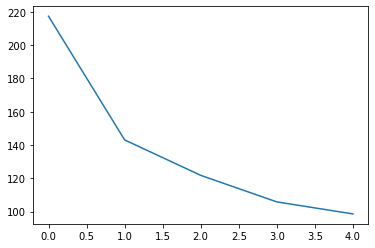

In [15]:
epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs)
number_of_correct_estimations = 0
for test_data in test_set:
    a0 = test_data[0]
    a1 = sigmoid(W1 @ a0 + b1)
    a2 = sigmoid(W2 @ a1 + b2)
    a3 = sigmoid(W3 @ a2 + b3)
    
    predicted_number = np.where(a3 == np.amax(a3))
    real_number = np.where(test_data[1] == np.amax(test_data[1]))
    
    if predicted_number == real_number:
        number_of_correct_estimations += 1
        
print(f"Accuracy: {number_of_correct_estimations / 100}")

# 6. Additional Steps
    6.1 Shifting image  
    6.2 Using another activation function  

## 6.1 Shifting image
In this section, we examine the consequence of shifting input images of the test set and its effect on the accuracy of our model. To do that, we can divide this section into two steps:
1. Training our model with full of the train set images.
2. test our model with a shifted version of the test set.

In [16]:
%%time
#1

total_costs = []
# Initialize W with random normal distribution for each layer.
W1 = np.random.normal(size=(16, NUMBER_OF_PIXELS))
W2 = np.random.normal(size=(16, 16))
W3 = np.random.normal(size=(10, 16))

# Initialize b = 0, for each layer.
b1 = np.zeros((16, 1))
b2 = np.zeros((16, 1))
b3 = np.zeros((10, 1))

for epoch in range(number_of_epochs):
    np.random.shuffle(train_set)
    batches = [train_set[x:x+batch_size] for x in range(0, len(train_set), batch_size)]
    for batch in batches:
        # allocate grad_W matrix for each layer
        grad_W1 = np.zeros((16, NUMBER_OF_PIXELS))
        grad_W2 = np.zeros((16, 16))
        grad_W3 = np.zeros((10, 16))
        # allocate grad_b for each layer
        grad_b1 = np.zeros((16, 1))
        grad_b2 = np.zeros((16, 1))
        grad_b3 = np.zeros((10, 1))
        
        for image, label in batch:
            # compute the output (image is equal to a0)
            a1 = sigmoid(W1 @ image + b1)
            a2 = sigmoid(W2 @ a1 + b2)
            a3 = sigmoid(W3 @ a2 + b3)
            
            # ---- Last layer
            # weight
            grad_W3 += (2 * (a3 - label) * a3 * (1 - a3)) @ np.transpose(a2)
            
            # bias
            grad_b3 += 2 * (a3 - label) * a3 * (1 - a3)
            
            # ---- 3rd layer
            # activation
            delta_3 = np.zeros((16, 1))
            delta_3 += np.transpose(W3) @ (2 *(a3 - label) * (a3 * (1 - a3)))
            
            # weight
            grad_W2 += (a2 * (1 - a2) * delta_3) @ np.transpose(a1)
            
            # bias
            grad_b2 += delta_3 * a2 * (1 - a2)
                    
            # ---- 2nd layer
            # activation
            delta_2 = np.zeros((16, 1))
            delta_2 += np.transpose(W2) @ delta_3 * a2 * (1 - a2)
            
            # weight
            grad_W1 += (delta_2 * a1 * (1 - a1)) @ np.transpose(image)
                    
            # bias
            grad_b1 += delta_2 * a1 * (1 - a1)
        
        W3 = W3 - (learning_rate * (grad_W3 / batch_size))
        W2 = W2 - (learning_rate * (grad_W2 / batch_size))
        W1 = W1 - (learning_rate * (grad_W1 / batch_size))
        
        b3 = b3 - (learning_rate * (grad_b3 / batch_size))
        b2 = b2 - (learning_rate * (grad_b2 / batch_size))
        b1 = b1 - (learning_rate * (grad_b1 / batch_size))
    
    # calculate cost average per epoch
    cost = 0
    for train_data in train_set:
        a0 = train_data[0]
        a1 = sigmoid(W1 @ a0 + b1)
        a2 = sigmoid(W2 @ a1 + b2)
        a3 = sigmoid(W3 @ a2 + b3)

        for j in range(10):
            cost += np.power((a3[j, 0] - train_data[1][j,  0]), 2)
            
    cost /= 100
    total_costs.append(cost)    

Wall time: 1min 25s


Before moving on to the second step, we construct a function that shifts the given image 4 pixels to the right. As a result, the image's last four columns are removed, and the first four columns' pixels are replaced with black pixels.

In [17]:
def shift_image(given_flat_image):
    image = given_flat_image.reshape(28, 28)
    shifted_image = np.roll(image, 4)
    shifted_image[:, 0] = np.zeros(28)
    shifted_image[:, 1] = np.zeros(28)
    shifted_image[:, 2] = np.zeros(28)
    shifted_image[:, 3] = np.zeros(28)
    
    return shifted_image.reshape(784, 1)

In [18]:
number_of_correct_estimations = 0
for test_data in test_set:
    a0 = shift_image(test_data[0])
    a1 = sigmoid(W1 @ a0 + b1)
    a2 = sigmoid(W2 @ a1 + b2)
    a3 = sigmoid(W3 @ a2 + b3)
    
    predicted_number = np.where(a3 == np.amax(a3))
    real_number = np.where(test_data[1] == np.amax(test_data[1]))
    
    if predicted_number == real_number:
        number_of_correct_estimations += 1
        
print(f"Accuracy: {number_of_correct_estimations / 100}")

Accuracy: 25.66


As we see from the result of the above segment, the accuracy <span style="color:red">has been reduced significantly</span>.
.  

**But why a 4 pixel shift to the right make it worse?** That's because the weights of the connections from all of the neurons from the first layer to a given neuron from the second layer create a pattern that, in the end, it leads to the diagnosis of which digit we're dealing with. But that only depends on the pixels that our model learns during the learning process. As a matter of fact, our model doesn't have the faintest idea of what's the meaning of each digit. It just knows what pixels on each position can lead to an expected result if they gather in one image.

## 6.2 Using another activation function 
We have several activation functions such as Sigmoid, Tanh, ReLU, and suchlike. Every one of them has its own cons and pros based on the application. In this part, we train our model with the ReLU function instead of the sigmoid.
![ReLU](assets/ReLU.jpg)

In [19]:
def ReLU(x):
    result = np.array(x)
    result[result < 0] = 0
    return result

def ReLU_derivative(x):
    result = np.zeros((x.shape[0], 1))
    result[x > 0] = 1
    
    return result

In [20]:
%%time
total_costs = []
# Initialize W with random normal distribution for each layer.
W1 = np.random.normal(size=(16, NUMBER_OF_PIXELS))
W2 = np.random.normal(size=(16, 16))
W3 = np.random.normal(size=(10, 16))

# Initialize b = 0, for each layer.
b1 = np.zeros((16, 1))
b2 = np.zeros((16, 1))
b3 = np.zeros((10, 1))

for epoch in range(number_of_epochs):
    np.random.shuffle(train_set)
    batches = [train_set[x:x+batch_size] for x in range(0, len(train_set), batch_size)]
    for batch in batches:
        # allocate grad_W matrix for each layer
        grad_W1 = np.zeros((16, NUMBER_OF_PIXELS))
        grad_W2 = np.zeros((16, 16))
        grad_W3 = np.zeros((10, 16))
        # allocate grad_b for each layer
        grad_b1 = np.zeros((16, 1))
        grad_b2 = np.zeros((16, 1))
        grad_b3 = np.zeros((10, 1))
        
        for image, label in batch:
            # compute the output (image is equal to a0)
            z1 = W1 @ image + b1
            a1 = ReLU(z1)
            z2 = W2 @ a1 + b2
            a2 = ReLU(z2)
            z3 = W3 @ a2 + b3
            a3 = ReLU(z3)
            
            # ---- Last layer
            # weight
            grad_W3 += (2 * (a3 - label) * ReLU_derivative(z3)) @ np.transpose(a2)
                        
            # bias
            grad_b3 += 2 * (a3 - label) * ReLU_derivative(z3)
            
            # ---- 3rd layer
            # activation
            delta_3 = np.zeros((16, 1))
            delta_3 += np.transpose(W3) @ (2 *(a3 - label) * ReLU_derivative(z3))
            
            # weight
            grad_W2 += (ReLU_derivative(z2) * delta_3) @ np.transpose(a1)
            
            # bias
            grad_b2 += delta_3 * ReLU_derivative(z2)
                    
            # ---- 2nd layer
            # activation
            delta_2 = np.zeros((16, 1))
            delta_2 += np.transpose(W2) @ delta_3 * ReLU_derivative(z2)
            
            # weight
            grad_W1 += (delta_2 * ReLU_derivative(z1)) @ np.transpose(image)
                    
            # bias
            grad_b1 += delta_2 * ReLU_derivative(z1)
        
        W3 = W3 - (learning_rate * (grad_W3 / batch_size))
        W2 = W2 - (learning_rate * (grad_W2 / batch_size))
        W1 = W1 - (learning_rate * (grad_W1 / batch_size))
        
        b3 = b3 - (learning_rate * (grad_b3 / batch_size))
        b2 = b2 - (learning_rate * (grad_b2 / batch_size))
        b1 = b1 - (learning_rate * (grad_b1 / batch_size))
    
    # calculate cost average per epoch
    cost = 0
    for train_data in train_set:
        a0 = train_data[0]
        a1 = ReLU(W1 @ a0 + b1)
        a2 = ReLU(W2 @ a1 + b2)
        a3 = ReLU(W3 @ a2 + b3)
        
        for j in range(10):
            cost += np.power((a3[j, 0] - train_data[1][j,  0]), 2)
            
    cost /= 100
    total_costs.append(cost)    

Wall time: 1min 27s


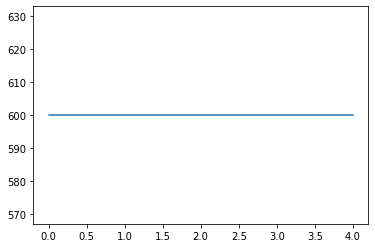

In [21]:
epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs);

As can be seen in the diagram above. Negative values are mapped to zero in ReLU. In layer calculations, we always end up with a negative value. As a result, each perceptron's value at the last layer is always 0, and each image's cost is always 1. This is called [Dying ReLU](https://arxiv.org/abs/1903.06733)

When we have millions of train data and the number of layers is too much, the ReLU function is appropriate. Since the sigmoid derivative is a number between 0 and 1, their output will be a number close to zero, and the learning process will suffer as a result.